## Content

1. Mathematics under the hood
1. 1-layer VAE to encode 1-bit information in 1-dim
1. 1-layer VAE to encode 1-bit information in n-dim
1. 2-layer VAE to encode 1-bit information in n-dim

## Mathematics under the hood

Derivation 1

\begin{align*}
log\left(p(x;\theta)\right) &= log\left(\int p(x,z;\theta)dz\right) \\
&= log\left(\int \frac{p(x,z;\theta)q(z|x;\phi)}{q(z|x;\phi)} dz\right) \\
&\ge \int log\left( \frac{p(x,z;\theta)}{q(z|x;\phi)} \right) q(z|x;\phi) dz \\
&= \int log\left( p(x|z;\theta) \right) q(z|x;\phi) dz + \int log\left( \frac{p(z;\theta)}{q(z|x;\theta)} \right) q(z|x;\phi) dz \\
&= E_{q(z|x;\phi)}\left[ log(p(x|z;\theta)) \right] - D_{KL}\left( q(z|x;\phi)||p(z;\theta) \right)
\end{align*} 

Derivation 2

\begin{align*}
D_{KL}(q(z|x;\phi)||p(z|x;\theta)) &= E_{q(z|x;\phi)}\left[ log\left( \frac{q(z|x;\phi)}{p(z|x;\theta)} \right) \right] \\
&= E_{q(z|x;\phi)}\left[ log\left( \frac{q(z|x;\phi)p(x;\theta)}{p(x|z;\theta)p(z;\theta)} \right) \right] \\
&= log(x;\theta) + D_{KL}\left( q(z|x;\phi)||p(z;\theta) \right) - E_{q(z|x;\phi)}\left[ log\left( log(x|z;\theta) \right) \right] \\
log(x;\theta) - D_{KL}(q(z|x;\phi)||p(z|x;\theta)) &= E_{q(z|x;\phi)}\left[ log\left( p(x|z;\theta) \right) \right] - D_{KL}\left( q(z|x;\phi)||p(z;\theta) \right)
\end{align*}

<b>Modelling in a Multi-stochastic layer VAE setting</b><br>

We are considering a setting where multi-stochastic layer is incorporated in modelling the latent space.<br>

Assumptions:<br>
1. In the following setting we will assume the prior to be a standard multivariate gaussian.
1. Assume all covariance matries to be diagnols for simplicity
1. The generation network will only be dependent on $z_{2}$, i.e $p(x|z;\theta) = p(x|z_{2};\theta)$


Let's break the the latent space into two layers represented by $z_{1},z_{2}$ and parameters modelling $q(z|x;\phi)$ into $\phi_{1},\phi_{2}$, such that<br>

\begin{align*}
q(z|x;\phi) &= q(z_{1},z_{2}|x;\phi) \\
&= q(z_{1}|x;\phi)q(z_{2}|z_{1},x;\phi) \\
&= q(z_{1}|x;\phi_{1})q(z_{2}|z_{1};\phi_{2})
\end{align*}

First let's consider the first term of the ELBO $E_{q(z|x;\phi)}\left[ log\left( p(x|z;\theta) \right) \right]$<br><br>
\begin{align*}
E_{q(z|x;\phi)}\left[ log\left( p(x|z;\theta) \right) \right] &= E_{q(z|x;\phi)}\left[ log\left( p(x|z_{1};\theta) \right) \right] \\
&= E_{q(z_{1}|x;\phi_{1})}\left[  log\left( p(x|z_{1};\theta) \right) \right]
\end{align*}

Next we consider the expansion for $D_{KL}\left( q(z|x;\phi)||p(z;\theta) \right)$<br><br>
\begin{align*}
D_{KL}\left( q(z|x;\phi)||p(z;\theta) \right) &= E_{q(z|x;\phi)}\left[ log\left( \frac{q(z|x;\phi)}{p(z;\theta)} \right) \right] \\
&= E_{q(z_{1},z_{2}|x;\phi)}\left[ log\left( \frac{q(z_{1},z_{2}|x;\phi)}{p(z_{1},z_{2};\theta)} \right) \right] \\
&= E_{q(z_{1},z_{2}|x;\phi)}\left[ log\left( \frac{q(z_{1}|x;\phi_{1})}{p(z_{1}|z_{2};\theta)} \right) \right] + E_{q(z_{1},z_{2}|x;\phi)}\left[ log\left( \frac{q(z_{2}|z_{1};\phi_{2})}{p(z_{2})} \right) \right] \\
\end{align*}


As seen in the standard VAE scenario, the $E[.]$ terms are evaluated using only a single instance of $z$ and justify the approach as we perform the operation in mini-batches and therefore expect an averaging to take place at that level and get decent results. This works well in practice and we will continue with a similar approach in this case as well.

In [1]:
'''
!if [ -d VAE ]; then rm -Rf VAE; fi
!git clone https://github.com/KayEs141193/VAE.git
!pip install ./VAE
'''

'\n!if [ -d VAE ]; then rm -Rf VAE; fi\n!git clone https://github.com/KayEs141193/VAE.git\n!pip install ./VAE\n'

## 1-layer VAE to encode 1-bit information in 1-dim

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from VAE.models import MultiLayerVAE
from VAE.utils import print_and_collect, plot_results
from VAE.trainer import create_basic_trainer, create_basic_evaluator
from VAE.loss import log_prob_ratio_normal, recon_loss_bernoulli, makeLossLayered
import ignite
from ignite.engine import Engine, Events
from tqdm import tqdm
from torch.optim.lr_scheduler import MultiplicativeLR

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

num_workers = 8 if cuda else 0 

In [4]:
def generate(k,ndim,device,mode=2):
    if mode == 2:
        return torch.cat([ torch.zeros(size=(k,ndim),device=device), torch.ones(size=(k,ndim),device=device) ])
    elif mode == 0:
        return torch.zeros(size=(k,ndim),device=device)
    else:
        return torch.ones(size=(k,ndim),device=device)

In [5]:
def solve(input_dim,latent_dim,hiddens_enc,hiddens_dec,shared_enc,shared_dec,lr,epochs,w=None):
    
    train_loader = DataLoader(generate(256,input_dim,device),batch_size=256,shuffle=True,num_workers=num_workers)
    
    kl_loss_layered = makeLossLayered(log_prob_ratio_normal,w)
    model = MultiLayerVAE.construct(input_dim,latent_dim,hiddens_enc,hiddens_dec,shared_enc,shared_dec,device)

    decay = np.exp(np.log(1e-4/lr)/epochs)
    optimizer = optim.Adam(model.parameters(),lr=lr)
    lr_scheduler = MultiplicativeLR(optimizer, lambda ei: decay)
    
    trainer = create_basic_trainer(model,optimizer,device,kl_loss=kl_loss_layered,recon_loss=recon_loss_bernoulli,mode=1)
    
    def changeLR(engine):
        lr_scheduler.step()
    
    trainer.add_event_handler(Events.EPOCH_COMPLETED, changeLR )
    
    trainer.run(train_loader,max_epochs=epochs)
    
    x = generate(1000,input_dim,device)
    x_recon, logstd_noise, z, mu_zs_prior, logstd_zs_prior, mu_zs, logstd_zs = model(x)
    
    train_result = {'recon_loss': recon_loss_bernoulli(x,x_recon,logstd_noise), 'kl_loss': kl_loss_layered(z, mu_zs_prior, logstd_zs_prior, mu_zs, logstd_zs), 'elbo_loss': None}
    train_result['elbo_loss'] = train_result['recon_loss'] + train_result['kl_loss']
    
    train_result['z0'] = model.mapToLatent(generate(500,input_dim,device,mode=0))
    train_result['z1'] = model.mapToLatent(generate(500,input_dim,device,mode=1))
    
    return model, train_result

In [6]:
input_dims = [1,10,100]
latent_dim = 1
hiddens_enc = [[{'dim':10,'act':'elu','bn':False}]]
hiddens_dec = [[{'dim':10,'act':'elu','bn':False}]]
shared_enc = True
shared_dec = True
lr = 0.005
epochs = 2000

train_result1 = []
for input_dim in tqdm(input_dims):
    model1, result1 = solve(input_dim,latent_dim,hiddens_enc,hiddens_dec,shared_enc,shared_dec,lr,epochs)
    train_result1.append(result1)

100%|██████████| 3/3 [01:27<00:00, 29.10s/it]


In [7]:
hiddens_enc = [[{'dim':10,'act':'elu','bn':False},{'dim':10,'act':'elu','bn':False}],
               [{'dim':100,'act':'elu','bn':False},{'dim':100,'act':'elu','bn':False}]]
hiddens_enc = [[{'dim':10,'act':'elu','bn':False},{'dim':10,'act':'elu','bn':False}],
               [{'dim':100,'act':'elu','bn':False},{'dim':100,'act':'elu','bn':False}]]
shared_enc = True
shared_dec = True
lr = 0.005
epochs = 2000

train_result2 = []
for input_dim in tqdm(input_dims):
    model2, result2 = solve(input_dim,latent_dim,hiddens_enc,hiddens_dec,shared_enc,shared_dec,lr,epochs)
    train_result2.append(result2)

100%|██████████| 3/3 [01:50<00:00, 36.94s/it]


In [8]:
torch.save(train_result1,'train_result1.pt')
torch.save(train_result2,'train_result2.pt')

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

def plot_result(train_hist1,train_hist2,dims):
    
    recon_loss1 = [ el['recon_loss'].item()/d for el,d in zip(train_hist1,dims) ]
    kl_loss1 = [ el['kl_loss'].item() for el in train_hist1 ]

    recon_loss2 = [ el['recon_loss'].item()/d for el,d in zip(train_hist2,dims) ]
    kl_loss2 = [ el['kl_loss'].item() for el in train_hist2 ]

    plt.figure(figsize=(16,4))
    
    ax = plt.subplot(1,3,1)
    ax.set(xscale='log')
    sns.lineplot(x=dims,y=recon_loss1,label='VAE 1-Layer',ax=ax)
    sns.lineplot(x=dims,y=recon_loss2,label='VAE 2-Layer',ax=ax)
    plt.title('Reconstruction Loss')
    plt.ylabel('nats/dim')
    plt.xlabel('dims')
   
    ax = plt.subplot(1,3,2)
    ax.set(xscale='log')
    sns.lineplot(x=dims,y=kl_loss1,label='VAE 1-Layer',ax=ax)
    sns.lineplot(x=dims,y=kl_loss2,label='VAE 2-Layer',ax=ax)
    plt.title('Kullback-Leibler Loss')
    plt.ylabel('nats')
    plt.xlabel('dims')
    
    ax = plt.subplot(1,3,3)
    ax.set(xscale='log')
    sns.lineplot(x=dims,y=[ l1+l2 for l1,l2 in zip(recon_loss1,kl_loss1) ],label='VAE 1-Layer',ax=ax)
    sns.lineplot(x=dims,y=[ l1+l2 for l1,l2 in zip(recon_loss2,kl_loss2) ],label='VAE 2-Layer',ax=ax)
    plt.title('ELBO Loss')
    plt.ylabel('nats')
    plt.xlabel('dims')

    plt.figure(figsize=(16,6))

    ax = plt.subplot(1,2,1)
    for el, d in zip(train_hist1,dims):
        sns.kdeplot(torch.cat([el['z0'],el['z1']]).flatten().cpu().detach().numpy(),label=str(d))
    plt.title('q(z|x) distribution VAE 1-Layer')
    plt.ylabel('q(z|x)')
    plt.xlabel('z')

    ax = plt.subplot(1,2,2)
    sns.kdeplot(train_hist1[-1]['z0'].flatten().cpu().detach().numpy(),label='x='+str(0),shade=True)
    sns.kdeplot(train_hist1[-1]['z1'].flatten().cpu().detach().numpy(),label='x='+str(1),shade=True)
    plt.title('q(z|x=i) distribution VAE 1-Layer {} dim'.format(dims[-1]))
    plt.ylabel('q(z|x=i)')
    plt.xlabel('z')

    plt.figure(figsize=(16,6))

    ax = plt.subplot(1,2,1)
    for el, d in zip(train_hist2,dims):
        sns.kdeplot(torch.cat([el['z0'],el['z1']]).flatten().cpu().detach().numpy(),label=str(d))
    plt.title('q(z2|x) distribution VAE 2-Layer')
    plt.ylabel('q(z2|x)')
    plt.xlabel('z')

    ax = plt.subplot(1,2,2)
    sns.kdeplot(train_hist2[-1]['z0'].flatten().cpu().detach().numpy(),label='x='+str(0),shade=True)
    sns.kdeplot(train_hist2[-1]['z1'].flatten().cpu().detach().numpy(),label='x='+str(1),shade=True)
    plt.title('q(z2|x=i) distribution VAE 2-Layer {} dim'.format(dims[-1]))
    plt.ylabel('q(z2|x=i)')
    plt.xlabel('z')

train_result1 = torch.load('train_result1.pt')
train_result2 = torch.load('train_result2.pt')

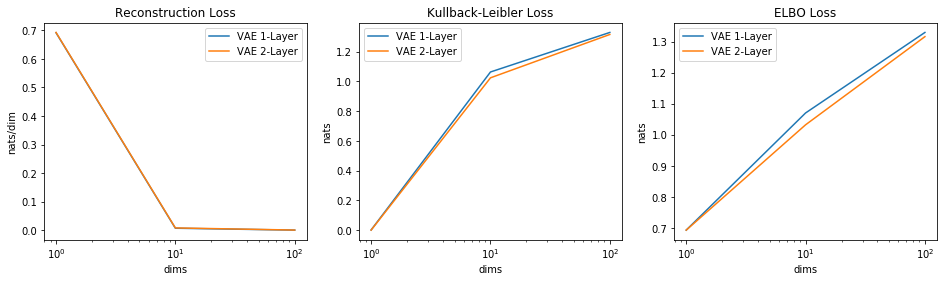

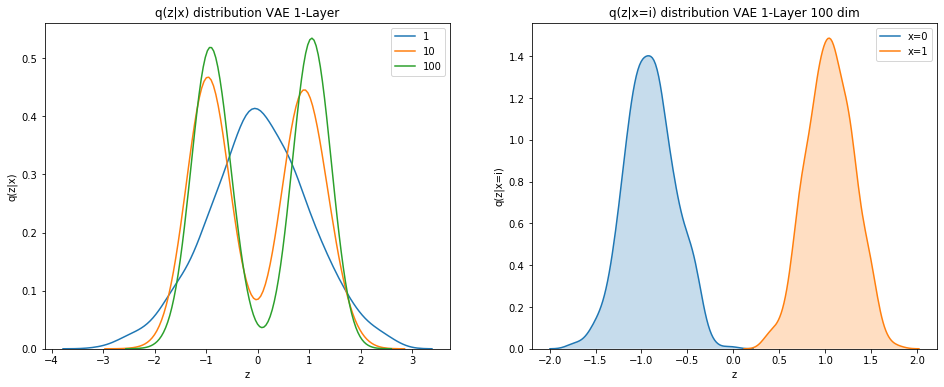

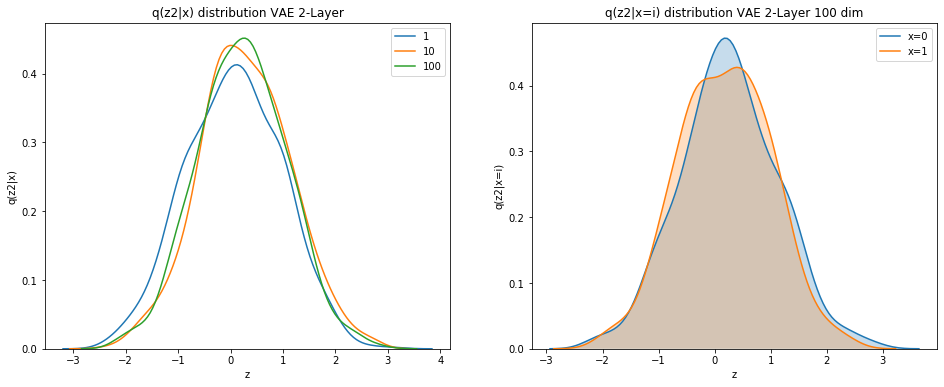

In [4]:
plot_result(train_result1,train_result2,[1,10,100])

<b>References</b>
1. http://ruishu.io/2017/01/14/one-bit/